This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Extrapolate projection centers from a mean

In this tutorial, we will extrapolate a plane of projection centers (PCs) from a mean PC.
The PCs are determined from patterns spread out across the sample region of interest (ROI).
This is an alternative to *fitting* a plane to PCs, as is demonstrated in the tutorial [Fit a plane to selected projection centers](pc_fit_plane.ipynb).
As a validation of the extrapolated PCs, we will compare them to the PCs obtained from fitting a plane to the PCs.

We'll start by importing the necessary libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from diffsims.crystallography import ReciprocalLatticeVector
import hyperspy.api as hs
import kikuchipy as kp
from orix.crystal_map import PhaseList


plt.rcParams.update(
    {
        "figure.facecolor": "w",
        "figure.dpi": 75,
        "figure.figsize": (8, 8),
        "font.size": 15,
    }
)

## Load and inspect data

We will use nine calibration patterns from recrystallized nickel.
The patterns are acquired with a NORDIF UF-1100 EBSD detector with the full (480, 480) px$^2$ resolution.
These patterns should always be acquired from spread out sample positions across the ROI in order to calibrate the PCs prior to indexing the full dataset.

Read the calibration patterns

In [2]:
s_cal = kp.data.ni_gain_calibration(1, allow_download=True)
s_cal

<EBSD, title: Calibration patterns, dimensions: (9|480, 480)>

Get information read from the NORDIF settings file

In [3]:
omd = s_cal.original_metadata.as_dictionary()

Plot coordinates of calibration patterns on the secondary electron area overview image (part of the dataset), highlighting the ROI

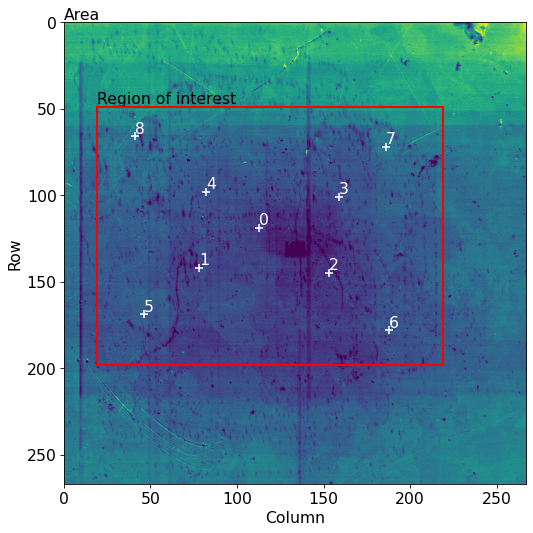

In [4]:
kp.draw.plot_pattern_positions_in_map(
    rc=omd["calibration_patterns"]["indices_scaled"],
    roi_shape=omd["roi"]["shape_scaled"],
    roi_origin=omd["roi"]["origin_scaled"],
    area_shape=omd["area"]["shape_scaled"],
    area_image=omd["area_image"],
    color="w",
)

Improve signal-to-noise ratio by removing the static and dynamic background

In [5]:
s_cal.remove_static_background("divide")
s_cal.remove_dynamic_background("divide")

[########################################] | 100% Completed | 105.57 ms
[########################################] | 100% Completed | 102.14 ms


Let's plot the nine background-corrected calibration patterns.

Before we do that, though, we find a suitable signal mask.
The mask should exclude parts of the pattern without Kikuchi diffraction.
Previous EBSD experiments on the microscope showed that the maximum intensity on the detector is a little to the left of the detector center.
We therefore use a circular mask to exclude intensities in the upper and lower right corners of the detector

In [6]:
r_pattern = kp.filters.distance_to_origin(
    s_cal.axes_manager.signal_shape[::-1], origin=(230, 220)
)
signal_mask = r_pattern > 310  # Exclude pixels set to True

For visual display only, we normalize intensities to a mean of 0 and a standard deviation of 1.
We also exclude extreme intensities outside the range [-3, 3].

In [7]:
s_cal2 = s_cal.normalize_intensity(dtype_out="float32", inplace=False)

[########################################] | 100% Completed | 101.30 ms


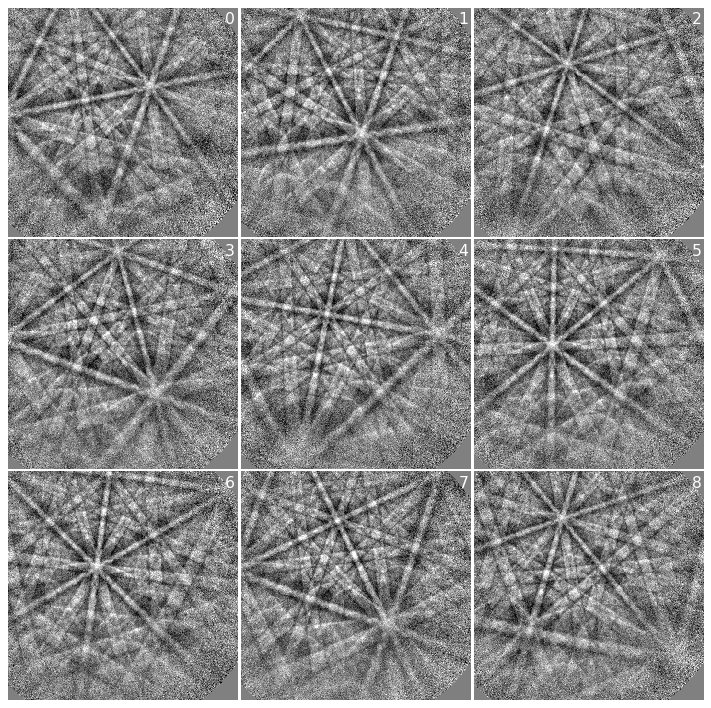

In [8]:
fig = plt.figure(figsize=(12, 12))
_ = hs.plot.plot_images(
    s_cal2 * ~signal_mask,
    per_row=3,
    axes_decor=None,
    colorbar=False,
    label=None,
    fig=fig,
    vmin=-3,
    vmax=3,
)
for i, ax in enumerate(fig.axes):
    ax.axis("off")
    ax.text(475, 10, str(i), va="top", ha="right", c="w")
fig.subplots_adjust(wspace=0.01, hspace=0.01)

We know that all patterns are of nickel.
To get a description of nickel, we could create a [Phase](https://orix.readthedocs.io/en/stable/reference/generated/orix.crystal_map.Phase.html) manually.
However, we will later on use a dynamically simulated EBSD master pattern of nickel (created with EMsoft), which is loaded with a `Phase`.
We will use this in the remaining analysis.

In [9]:
mp = kp.data.ebsd_master_pattern(
    "ni", allow_download=True, projection="lambert", energy=20
)
mp

<EBSDMasterPattern, title: ni_mc_mp_20kv, dimensions: (|1001, 1001)>

Extract the phase, and change the lattice parameter unit from nm to Ångström

In [10]:
phase = mp.phase

lat = phase.structure.lattice
lat.setLatPar(lat.a * 10, lat.b * 10, lat.c * 10)

In [11]:
print(phase)
print(phase.structure)

<name: ni. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>
lattice=Lattice(a=3.5236, b=3.5236, c=3.5236, alpha=90, beta=90, gamma=90)
28   0.000000 0.000000 0.000000 1.0000


## Estimate PCs with Hough indexing

We will estimate PCs for the nine calibration patterns using [PyEBSDIndex](https://pyebsdindex.readthedocs.io).
See the [Hough indexing tutorial](hough_indexing.rst) for more details.

<div class="alert alert-info">

Note

PyEBSDIndex is an optional dependency of kikuchipy, and can be installed with both `pip` and `conda` (from `conda-forge`).
To install PyEBSDIndex, see their [installation instructions](https://pyebsdindex.readthedocs.io/en/latest/user/installation.html).

</div>

We need an [EBSDIndexer](https://pyebsdindex.readthedocs.io/en/stable/reference/generated/pyebsdindex.ebsd_index.EBSDIndexer.html) to use `PyEBSDIndex`.
We can obtain an indexer by passing a [PhaseList](https://orix.readthedocs.io/en/stable/reference/generated/orix.crystal_map.PhaseList.html) to [EBSDDetector.get_indexer()](../reference/generated/kikuchipy.detectors.EBSDDetector.get_indexer.rst).
Therefore, we need an initial EBSD detector

In [12]:
det_cal = s_cal.detector

print(det_cal)
print(det_cal.sample_tilt)

EBSDDetector(shape=(480, 480), pc=(0.5, 0.5, 0.5), sample_tilt=70.0, tilt=0.0, azimuthal=0.0, binning=1.0, px_size=1.0 um)
70.0


In [13]:
pl = PhaseList(phase)
pl

Id  Name  Space group  Point group  Proper point group     Color
 0    ni        Fm-3m         m-3m                 432  tab:blue

In [14]:
indexer = det_cal.get_indexer(pl, rhoMaskFrac=0.05)

print(indexer.phaselist[0].phasename)
print(indexer.bandDetectPlan.rhoMaskFrac)

ni
0.05


We estimate the PC of each pattern with Hough indexing, and plot both the mean and standard deviation of the resulting PCs.
Note that Bruker's PC convention is used in kikuchipy.
(We will "overwrite" the existing detector variable.)

In [15]:
det_cal = s_cal.hough_indexing_optimize_pc(
    pc0=[0.42, 0.21, 0.50],  # Initial guess based on previous experiments
    indexer=indexer,
    batch=True,
    method="PSO",
    search_limit=0.1,
)

print(det_cal.pc.mean(axis=0))
print(det_cal.pc.std(0))


PC found: [********* ] 9/9  global best:0.158  PC opt:[0.425  0.2305 0.4995]
[0.41901404 0.21758671 0.49856001]
[0.00453698 0.00662614 0.00577425]


Plot the PCs

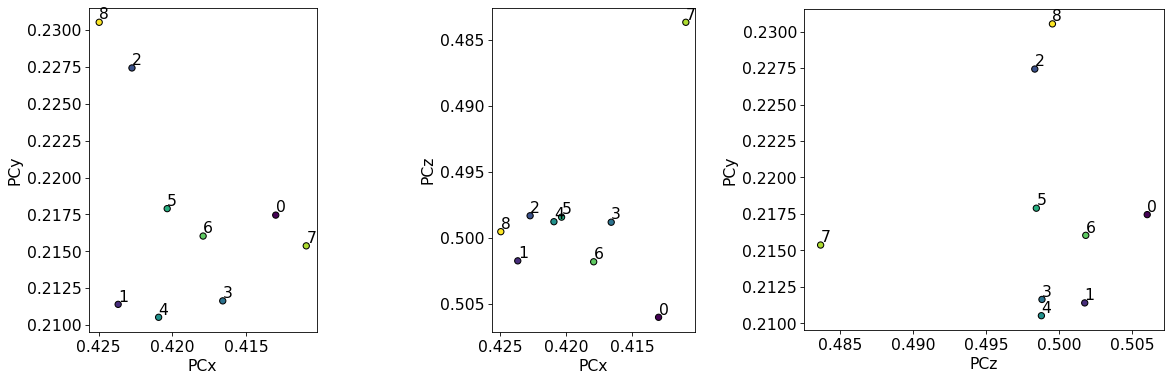

In [16]:
det_cal.plot_pc("scatter", annotate=True)

Unfortunately, we do not recognize the spatial distribution from the overview image above.
The expected inverse relation between (PCz, PCy) is not present either.
We can try to improve indexing by refining the PCs using dynamical simulations.
These simulations are created with EMsoft.

First, we need an initial guess of the orientations, which we get using Hough indexing via [EBSD.hough_indexing()](../reference/generated/kikuchipy.signals.EBSD.hough_indexing.rst).
We will use the mean PC for all patterns

In [17]:
indexer.PC = det_cal.pc_average

Hough indexing with PyEBSDIndex information:
  PyOpenCL: True
  Projection center (Bruker): (0.419, 0.2176, 0.4986)
  Indexing 9 pattern(s) in 1 chunk(s)
Radon Time: 0.011963875003857538
Convolution Time: 0.02135316701605916
Peak ID Time: 0.023419334000209346
Band Label Time: 0.015215041988994926
Total Band Find Time: 0.0720773330249358
Band Vote Time:  0.004266916977940127
  Indexing speed: 104.25207 patterns/s


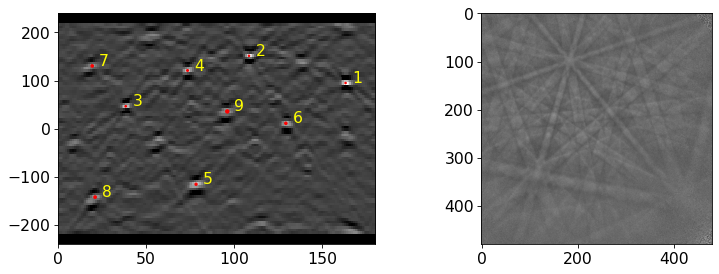

In [18]:
xmap_hi = s_cal.hough_indexing(pl, indexer=indexer, verbose=2)

In [19]:
print(xmap_hi)
print(xmap_hi.fit.mean())

Phase  Orientations  Name  Space group  Point group  Proper point group     Color
    0    9 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: fit, cm, pq, nmatch
Scan unit: um
0.2826037


## Refine PCs with pattern matching

Refine the PCs (and orientations) using the Nelder-Mead implementation from NLopt

In [20]:
xmap_ref, det_ref = s_cal.refine_orientation_projection_center(
    xmap=xmap_hi,
    detector=det_cal,
    master_pattern=mp,
    signal_mask=signal_mask,
    energy=20,
    method="LN_NELDERMEAD",
    trust_region=[5, 5, 5, 0.05, 0.05, 0.05],
    rtol=1e-6,
    # A pattern per iteration to use all CPUs
    chunk_kwargs=dict(chunk_shape=1),
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5.   5.   5.   0.05 0.05 0.05]
  Relative tolerance: 1e-06
Refining 9 orientation(s) and projection center(s):
[########################################] | 100% Completed | 11.30 ss
Refinement speed: 0.79589 patterns/s


Inspect some refinement statistics

In [21]:
print("Score mean:                ", xmap_ref.scores.mean())
print("Mean number of evaluations:", xmap_ref.num_evals.mean())
print("PC mean:     ", det_ref.pc.mean(0))
print("PC std:      ", det_ref.pc.std(0))
print("PC max. diff:", abs(det_cal.pc - det_ref.pc).max(0))

angles = xmap_hi.orientations.angle_with(xmap_ref.orientations, degrees=True)
print("Ori. max. diff [deg]:", angles.max())

Score mean:                 0.5226784944534302
Mean number of evaluations: 377.77777777777777
PC mean:      [0.42068974 0.21332436 0.50040134]
PC std:       [0.00254062 0.00182808 0.00065646]
PC max. diff: [0.0076474  0.01716238 0.01609581]
Ori. max. diff [deg]: 1.2169517422386968


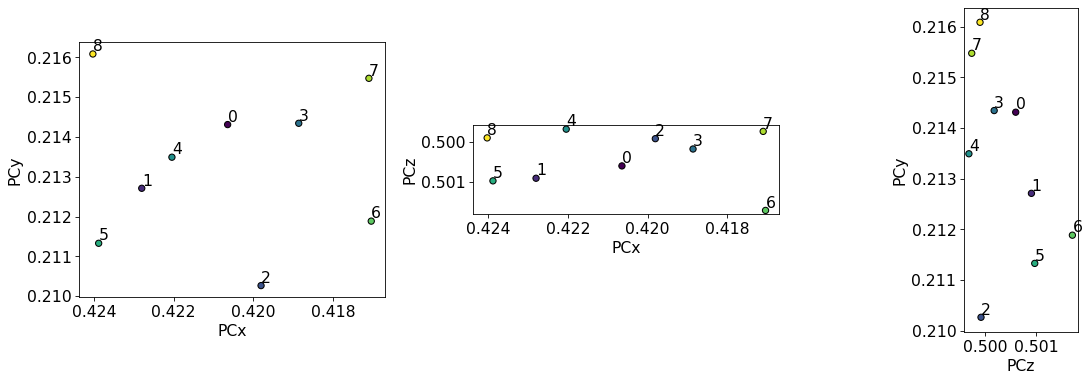

In [22]:
det_ref.plot_pc("scatter", annotate=True)

The diagonals 5-1-0-3-7 and 8-4-0-2-6 seen in the overview image above should be replicated in the (PCx, PCy) scatter plot.
We see that 5-1-0-3-7 and 8-0-6 align as expected, but the PC values from the 2nd and 4th patterns do not lie in the expected range.
Fitting a plane to all these values might not work to our satisfaction, so we will exclude the 2nd and 4th PC values when fitting a plane to the seven remaining PC values.
The plane will have PC values for all points in the ROI in the overview image above.

In [23]:
is_outlier = np.zeros(det_ref.navigation_size, dtype=bool)
is_outlier[[2, 4]] = True

## Get PC plane by fitting

The fitting is done by finding a transformation function which takes 2D sample coordinates and gives PC values for those coordinates.
Both an affine and a projective transformation function is supported, following <cite data-cite="winkelmann2020refined">Winkelmann et al. (2020)</cite>.
By passing 2D indices of all ROI map points and of the points where the nine calibration patterns were obtained, [EBSDDetector.fit_pc()](../reference/generated/kikuchipy.detectors.EBSDDetector.fit_pc.rst) returns a new detector with PC values for all map points.
We will use the maximum difference between the above refined PC values and the corresponding fitted PC values as a measure of how good the fitted PC values are.

In [24]:
pc_indices = omd["calibration_patterns"]["indices_scaled"]
pc_indices -= omd["roi"]["origin_scaled"]
pc_indices = pc_indices.T

map_indices = np.indices(omd["roi"]["shape_scaled"])
print("Full map shape (n rows, n columns):", omd["roi"]["shape_scaled"])

Full map shape (n rows, n columns): (149, 200)


Fit PC values using the affine transformation function

[0.42049695 0.2136612  0.50060621]
69.0763776359743


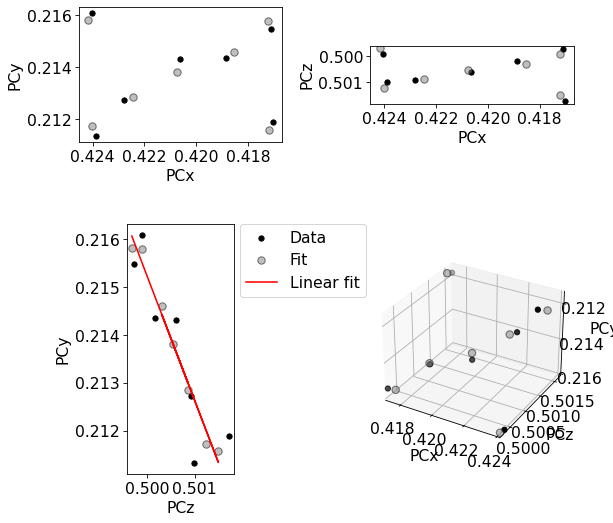

In [25]:
det_fit_aff = det_ref.fit_pc(
    pc_indices=pc_indices,
    map_indices=map_indices,
    transformation="affine",
    is_outlier=is_outlier,
)

print(det_fit_aff.pc_average)
print(det_fit_aff.sample_tilt)

Fit PC values using the projective transformation function

[0.42049361 0.21365742 0.50060609]
70.17715141525542


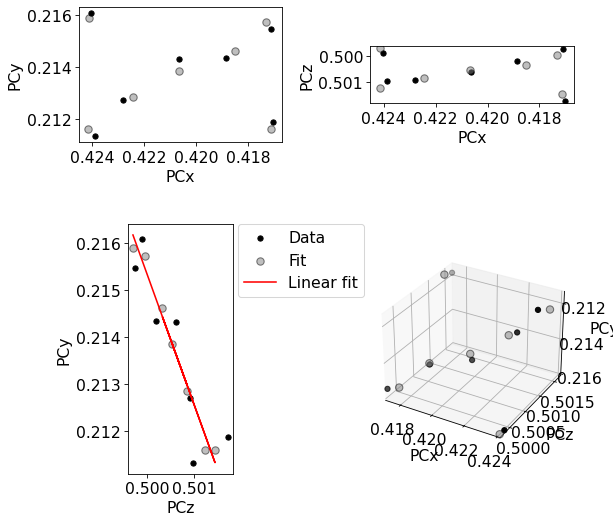

In [26]:
det_fit_proj = det_ref.fit_pc(
    pc_indices=pc_indices,
    map_indices=map_indices,
    transformation="projective",
    is_outlier=is_outlier,
)

print(det_fit_proj.pc_average)
print(det_fit_proj.sample_tilt)

Compare PC differences of all but the PC values from the 2nd and 4th patterns

In [27]:
pc_indices2 = pc_indices.T[~is_outlier].T

# Refined PC values as a reference (ground truth)
pc_ref = det_ref.pc[~is_outlier]

# Difference in PC values from the affine transformation function
pc_diff_aff = det_fit_aff.pc[tuple(pc_indices2)] - pc_ref
pc_diff_aff_max = abs(pc_diff_aff).max(axis=0)
print(pc_diff_aff_max)

# Difference in PC values from the projective transformation function
pc_diff_proj = det_fit_proj.pc[tuple(pc_indices2)] - pc_ref
pc_diff_proj_max = abs(pc_diff_proj).max(axis=0)
print(pc_diff_proj_max)

# Which fitted PCs are more different from refined PCs, the projective (True)
# or the affine (False)?
print(pc_diff_proj_max > pc_diff_aff_max)

[0.00034872 0.00050204 0.00026352]
[0.00036921 0.00046236 0.0002793 ]
[ True False  True]


## Get PC plane by extrapolation

Instead of fitting a plane to several PCs, we can extrapolate an average PC using [EBSDDetector.extrapolate_pc()](../reference/generated/kikuchipy.detectors.EBSDDetector.extrapolate_pc.rst).
To do this we need to know the detector pixel size and map step sizes, both given in the same unit.

In [28]:
det_ext = det_ref.extrapolate_pc(
    pc_indices=pc_indices,
    navigation_shape=omd["roi"]["shape_scaled"],
    step_sizes=(1.5, 1.5),  # um
    shape=det_cal.shape,
    px_size=70,  # In um. Generally unique for every detector model!
    is_outlier=is_outlier,
)

print(det_ext.pc_average)
print(det_ext.sample_tilt)

[0.4195733  0.21407237 0.50045177]
70.0


Difference in PC values between the refined PCs and the corresponding extrapolated PCs

In [29]:
pc_diff_ext = det_ext.pc[tuple(pc_indices2)] - pc_ref
pc_diff_ext_max = abs(pc_diff_ext).max(axis=0)
print(pc_diff_ext_max)
print(pc_diff_ext_max > pc_diff_proj_max)

[0.00142205 0.00081142 0.00042825]
[ True  True  True]


The extrapolated PCs deviate more from the refined PCs than the PCs obtained from fitting, although the difference is small.

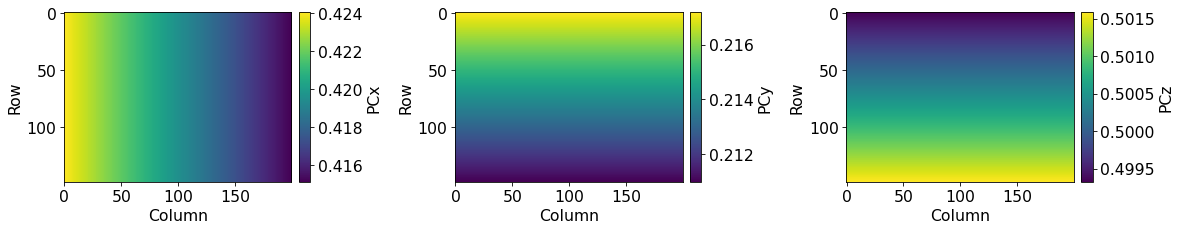

In [30]:
det_ext.plot_pc()

## Validate extrapolated PCs

As a final check of the difference in PCs, we can plot the geometrical simulations on top of the patterns using the refined orientation but the three different PCs.

In [31]:
g = ReciprocalLatticeVector.from_min_dspacing(phase.deepcopy())

g.sanitise_phase()  # "Fill atoms in the unit cell"

g.calculate_structure_factor()

F = abs(g.structure_factor)
g = g[F > 0.5 * F.max()]

g.print_table()

 h k l      d     |F|_hkl   |F|^2   |F|^2_rel   Mult 
 1 1 1    2.034    11.8     140.0     100.0      8   
 2 0 0    1.762    10.4     108.2      77.3      6   
 2 2 0    1.246     7.4     55.0       39.3      12  
 3 1 1    1.062     6.2     38.6       27.6      24  


In [32]:
simulator = kp.simulations.KikuchiPatternSimulator(g)

Using PCs from the affine transformation function

In [33]:
det_aff_cal = det_fit_aff.deepcopy()
det_aff_cal.pc = det_aff_cal.pc[tuple(pc_indices)]

In [34]:
xmap_aff = s_cal.refine_orientation(
    xmap=xmap_hi,
    detector=det_aff_cal,
    master_pattern=mp,
    energy=20,
    signal_mask=signal_mask,
    method="LN_NELDERMEAD",
    trust_region=[5, 5, 5],
    rtol=1e-6,
    chunk_kwargs={"chunk_shape": 1},
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5 5 5]
  Relative tolerance: 1e-06
Refining 9 orientation(s):
[########################################] | 100% Completed | 2.10 sms
Refinement speed: 4.28114 patterns/s


In [35]:
sim_aff = simulator.on_detector(det_aff_cal, xmap_aff.rotations)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 105.57 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 106.45 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 107.23 ms


Using PCs from the projective transformation function

In [36]:
det_proj_cal = det_fit_proj.deepcopy()
det_proj_cal.pc = det_proj_cal.pc[tuple(pc_indices)]

In [37]:
xmap_proj = s_cal.refine_orientation(
    xmap=xmap_hi,
    detector=det_proj_cal,
    master_pattern=mp,
    energy=20,
    signal_mask=signal_mask,
    method="LN_NELDERMEAD",
    trust_region=[5, 5, 5],
    rtol=1e-6,
    chunk_kwargs={"chunk_shape": 1},
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5 5 5]
  Relative tolerance: 1e-06
Refining 9 orientation(s):
[########################################] | 100% Completed | 2.01 sms
Refinement speed: 4.47958 patterns/s


In [38]:
sim_proj = simulator.on_detector(det_proj_cal, xmap_proj.rotations)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 105.96 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 106.33 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 106.57 ms


Using the extrapolated PCs

In [39]:
det_ext_cal = det_ext.deepcopy()
det_ext_cal.pc = det_ext_cal.pc[tuple(pc_indices)]

In [40]:
xmap_ext = s_cal.refine_orientation(
    xmap=xmap_hi,
    detector=det_ext_cal,
    master_pattern=mp,
    energy=20,
    signal_mask=signal_mask,
    method="LN_NELDERMEAD",
    trust_region=[5, 5, 5],
    rtol=1e-6,
    chunk_kwargs={"chunk_shape": 1},
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5 5 5]
  Relative tolerance: 1e-06
Refining 9 orientation(s):
[########################################] | 100% Completed | 2.22 sms
Refinement speed: 4.04475 patterns/s


In [41]:
sim_ext = simulator.on_detector(det_ext_cal, xmap_ext.rotations)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 101.93 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 105.95 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 106.52 ms


Compare normalized cross-correlation scores and number of evaluations (iterations)

In [42]:
print("Scores\n------")
print(f"Affine:       {xmap_aff.scores.mean():.7f}")
print(f"Projective:   {xmap_proj.scores.mean():.7f}")
print(f"Extrapolated: {xmap_ext.scores.mean():.7f}\n")

print("Number of evaluations\n---------------------")
print(f"Affine:       {xmap_aff.num_evals.mean():.1f}")
print(f"Projective:   {xmap_proj.num_evals.mean():.1f}")
print(f"Extrapolated: {xmap_ext.num_evals.mean():.1f}")

Scores
------
Affine:       0.5224591
Projective:   0.5224518
Extrapolated: 0.5221255

Number of evaluations
---------------------
Affine:       108.4
Projective:   100.9
Extrapolated: 110.1


Plot Kikuchi bands on top of patterns for the solutions using the affine transformed PCs (red), projective transformed PCs (blue), and extrapolated PCs (white)

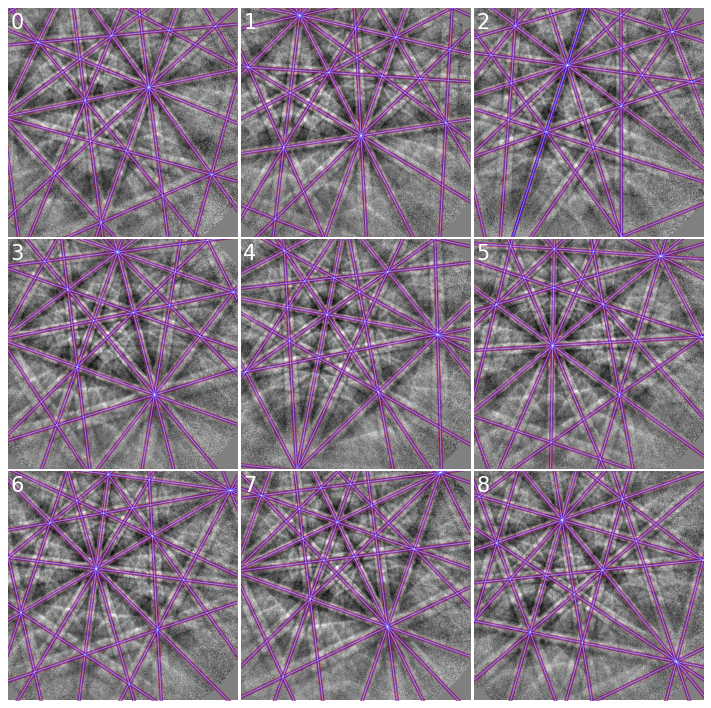

In [43]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(
        s_cal2.inav[i].data * ~signal_mask, cmap="gray", vmin=-3, vmax=3
    )
    ax.axis("off")

    # Affine
    lines = sim_aff.as_collections(
        i, lines_kwargs={"linewidth": 4, "alpha": 0.4}
    )[0]
    ax.add_collection(lines)

    # Projective
    lines = sim_proj.as_collections(
        i, lines_kwargs={"color": "b", "linewidth": 3, "alpha": 0.4}
    )[0]
    ax.add_collection(lines)

    # Extrapolated
    lines = sim_ext.as_collections(
        i, lines_kwargs={"color": "w", "linewidth": 1, "alpha": 0.4}
    )[0]
    ax.add_collection(lines)

    ax.text(5, 10, i, c="w", va="top", ha="left", fontsize=20)
fig.subplots_adjust(wspace=0.01, hspace=0.01)

As expected from the intermediate results above (similar average PC and NCC score), all PCs produce visually identical geometrical simulations.
However, the orientations may be slightly different

In [44]:
xmap_proj.orientations.angle_with(xmap_ext.orientations, degrees=True).mean()

0.17079371568748258

The estimated orientations using PCs from plane fitting are on average misoriented by about 1$^{\circ}$ from the estimated orientations using extrapolated PCs.
The misorientation is most likely a result of the difference in applied sample tilts

In [45]:
abs(det_proj_cal.sample_tilt - det_ext_cal.sample_tilt)

0.17715141525542322

Since these are experimental data, it's difficult to say which sample tilt is more correct, although the nominal sample tilt from the microscope was 70$^{\circ}$.